In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')

In [3]:
# Feature Engineering
features = [column for column in data.columns if column not in ['Id', 'Class']]
target = 'Class'
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category').cat.codes

In [4]:
# Remove inf and fill NaNs
for column in features:
    data[column] = data[column].replace([np.inf, -np.inf], np.nan)
    data[column] = data[column].fillna(data[column].median())

In [5]:
# Initial Random Forest to get feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(data[features], data[target])
importances = rf.feature_importances_

In [6]:
# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

In [7]:
# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Select top features
top_features = feature_importances['Feature'][:15]  

# Only use top features for X
X = data[top_features]
y = data[target]

In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Model Definition with hyperparameters
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)

In [11]:
# Cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='neg_log_loss')
log_loss_scores = -scores
print(f'Log Loss scores for each fold: {log_loss_scores}')
average_log_loss = np.mean(log_loss_scores)
print(f'Average Log Loss: {average_log_loss}')

Log Loss scores for each fold: [0.26884601 0.18671168 0.20428431 0.25647576 0.3816736  0.21844095
 0.28743277 0.19909164 0.20006771 0.28281357]
Average Log Loss: 0.24858380063474997


In [12]:
# Training the model
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

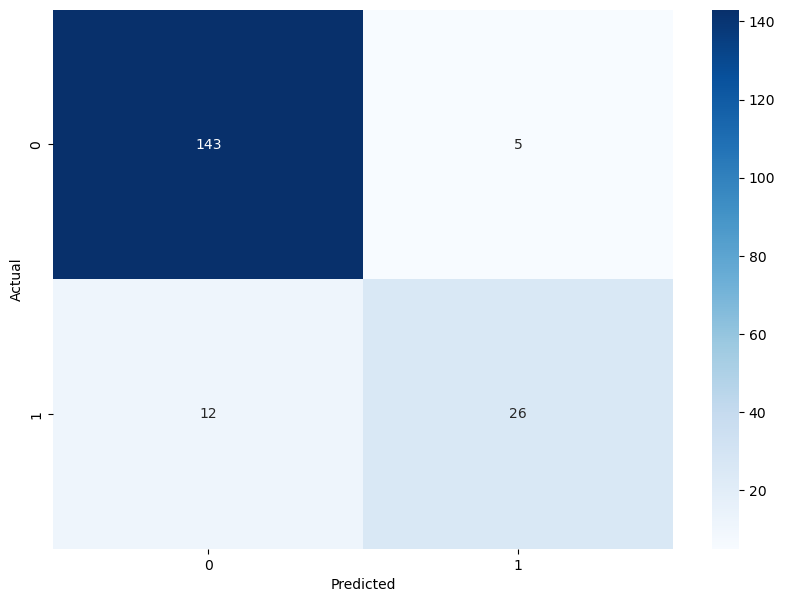

In [13]:
# Confusion Matrix
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
# Testing
test_data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ids = test_data['Id']
test_data = test_data.drop('Id', axis=1)
test_data = test_data.replace([np.inf, -np.inf], np.nan)
test_data.fillna(test_data.median(numeric_only=True), inplace=True)
test_data_scaled = scaler.transform(test_data[top_features])
test_preds = model.predict_proba(test_data_scaled)

In [15]:
# Create a submission file
submission = pd.DataFrame(test_ids, columns=['Id'])
submission[['class_0', 'class_1']] = test_preds
submission.to_csv('submission.csv', index=False)